# Assignment 4: Anomaly Detection with VAEs


<b>Group [30]</b>
* <b> Student </b> : Rehan Fazal + 1423002

As we have seen, Variational Autoencoders (VAEs) provide a mathematically grounded framework for the unsupervised learning of latent representations. Besides interpreting VAEs as representation learning or generative modelling, we can also see them as performing (approximate) density approximation. VAEs are trained to optimise a lower bound to the (log) likelihood $\log p(X)$ of the data $X$, under the chosen model. So, for any point in data space, we can obtain an estimate of its likelihood under the trained model, by simply computing the loss function when passing this data point through the neural network (note that the loss function is the negative ELBO, so we need to multiply by -1 to obtain a likelihood estimation).

We can use this idea to perform unsupervised anomaly detection. Suppose we are given a dataset that describes some natural distribution (e.g. images of certain clothing items). For new test data, we then wish to detect whether it fits this distribution, or is significantly different (an anomaly). For example, given a dataset of shirts, we want to detect anomalies in a test data set that also contains some images of trousers. Typically, such a situation occurs when we have many examples of one class (e.g. shirts), but very few of others (the anomalies, e.g. trousers).

In this task, we will perform and evaluate such anomaly detection with VAEs. Given a training data set that consists of instances that we consider "normal", we wish to detect anomalies in a test data set that contains both "normal" (but unseen) examples, as well as other examples which we consider anomalous. The idea is to train a VAE on the training data, such that it learns to represent "normal" data well. We can then compute the ELBO values for the test data, where ideally "normal" examples should obtain higher likelihood values than anomalous examples.

In this assignment, we will use FashionMNIST to simulate the anomaly detection task. We will omit one class from the training data, and consider the remaining 9 classes to be "normal". The goal is then to identify the omitted class in the test data, by comparing the ELBO values obtained from a VAE trained on 9 classes.

**NOTE:**
* **Only fill in the cells marked with `#### INSERT CODE HERE ####` or `<-- WRITE TEXT HERE -->`**
* **Do not add or delete any cells**
* **Make sure to run all cells before handing in.**
* **Re-running all cells in your notebook in order should produce similar output (it may vary slightly due to stochasticity in the training).**
* **You don't need to extensively comment your code, but briefly mention any assumptions you make, or any design choices.**
* **Make sure that the cell output (where needed) is clear and easy to interpret (i.e. print what it is you are outputting, captions/titles for plots).**

## Imports
These should be all the imports you'll need, please don't use any other libraries as this will make it harder to assess your work.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K

import tensorflow as tf

from sklearn.metrics import roc_curve, precision_recall_curve, auc

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Task 1: Obtain anomaly detection dataset
**(a)** We will consider the "Trouser" class (with label 1) to be the anomalies, and consider the other 9 classes to be our "normal" data. We'll train on normal data only, but we want to test on both normal and anomalous data to evaluate our anomaly detection framework.
* Load the FashionMNIST dataset.
* Remove all instances from the anomaly class from the training set.
* Split the test set in two parts: the anomalous data (with label 1) and the normal data (all other labels).

*Implementation hint: `np.argwhere` may be helpful for splitting the data based on its labels.*

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#remove trousers from train
ids = np.argwhere(y_train==1)
x_train = np.delete(x_train,ids,0)
y_train = np.delete(y_train,ids)

#split test in 2 parts (label 1, Other)
ids_0 = np.argwhere(y_test!=1)
ids_1 = np.argwhere(y_test==1)

x_test_0 = np.delete(x_test,ids_1,0)
y_test_0 = np.delete(y_test,ids_1)

x_test_1 = np.delete(x_test,ids_0,0)
y_test_1 = np.delete(y_test,ids_0)

#normalize
x_train = x_train.astype('float32') / 255
x_test_0 = x_test_0.astype('float32') / 255
x_test_1 = x_test_1.astype('float32') / 255

print("y_train:", len(y_train))
print("total test:", len(y_test))
print("Normal test:", len(y_test_0))
print("Anomaly test:", len(y_test_1))

#n_train, height, width, depth = x_train.shape

# print shapes
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of x_test_0: {}".format(x_test_0.shape))
print("Shape of x_test_1: {}".format(x_test_1.shape))

4423680/4422102 [==============================] - 0s 0us/step
y_train: 54000
total test: 10000
Normal test: 9000
Anomaly test: 1000
Shape of x_train: (54000, 28, 28)
Shape of x_test: (10000, 28, 28)
Shape of x_test_0: (9000, 28, 28)
Shape of x_test_1: (1000, 28, 28)


**(b)** To check if the split was done correctly, plot some random examples (at least 10 each) of:
* The new training set (without the anomaly class)
* The normal test set
* The anomaly test set

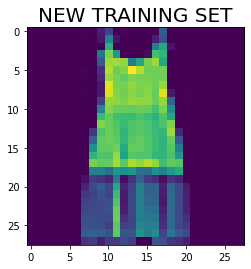

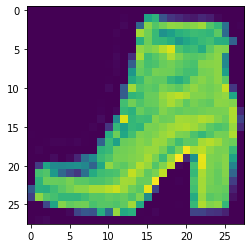

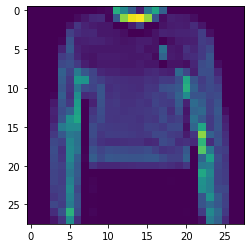

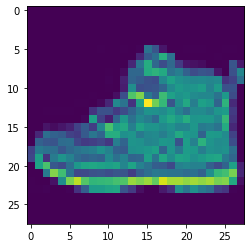

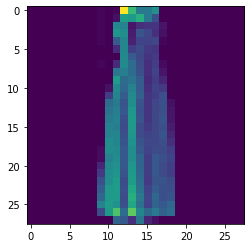

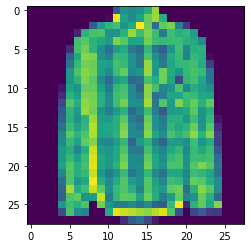

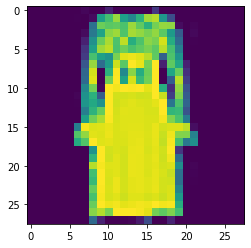

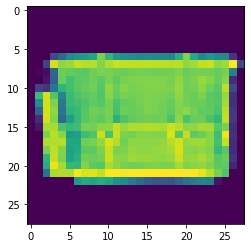

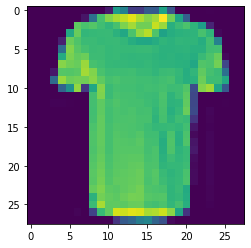

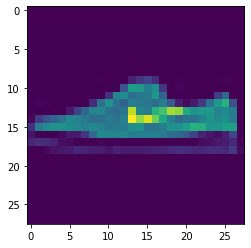

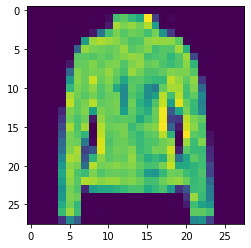

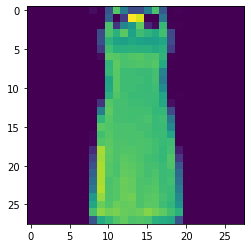

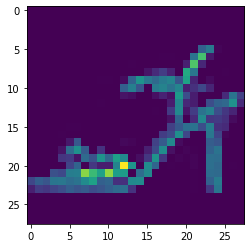

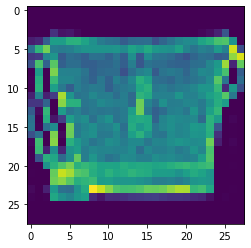

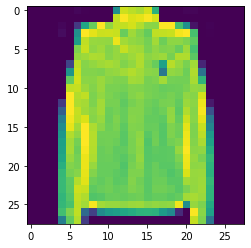



##############################




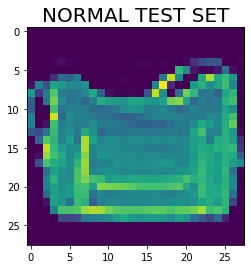

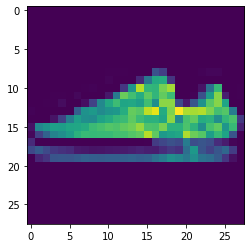

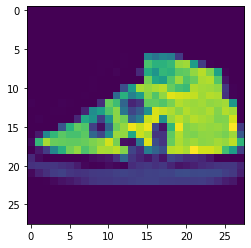

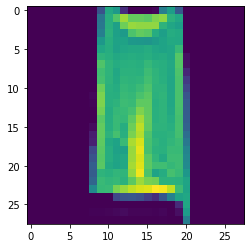

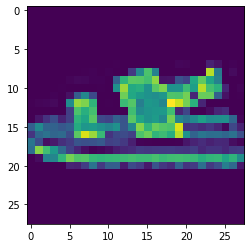

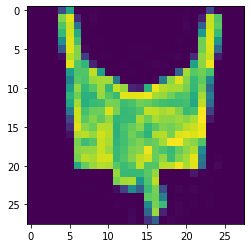

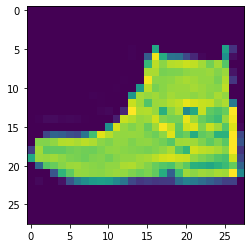

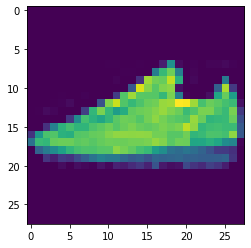

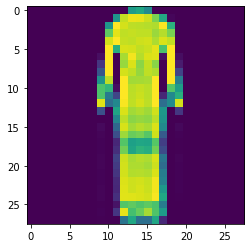

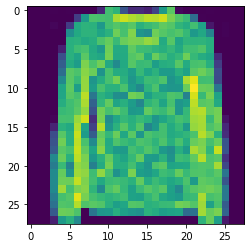

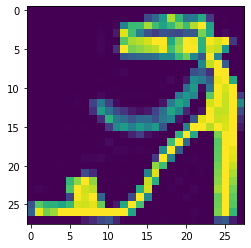

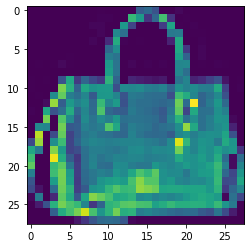

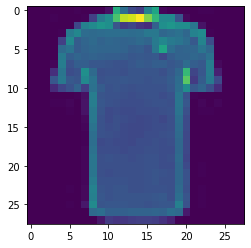

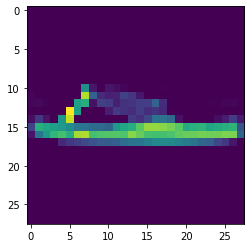

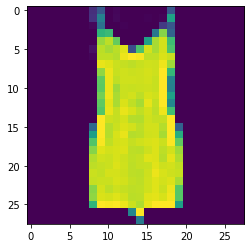



##############################




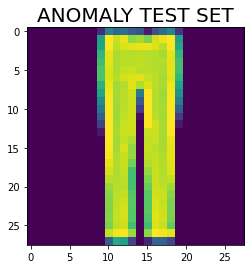

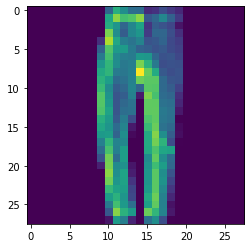

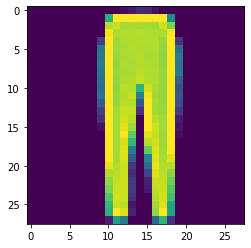

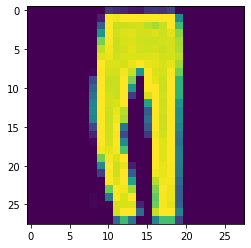

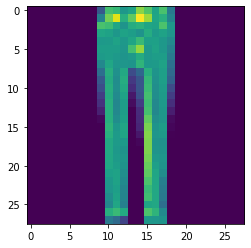

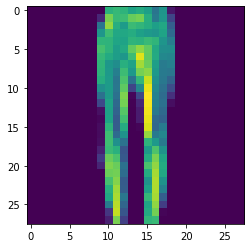

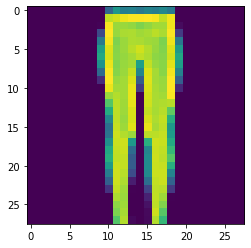

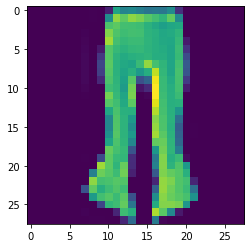

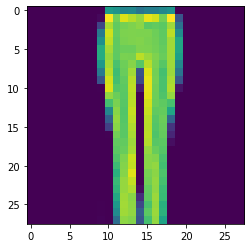

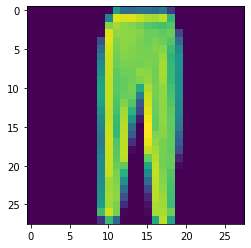

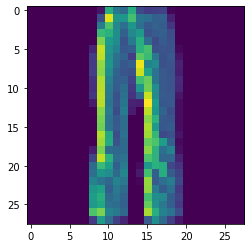

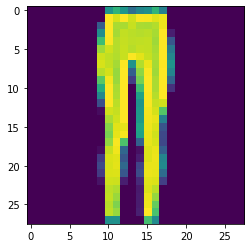

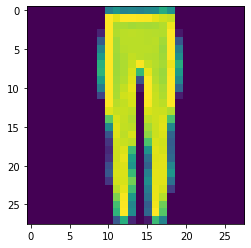

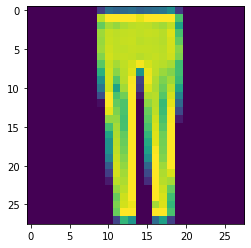

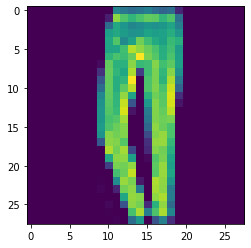

In [ ]:
#### INSERT CODE HERE ####
plt.title("NEW TRAINING SET", fontsize = 20, y=1)
for i in range(15):
  idx = np.random.randint(0, len(y_train))
  plt.imshow(x_train[idx % x_train.shape[0], ...])

  plt.show()

print("\n")
print("##############################")
print("\n")

plt.title("NORMAL TEST SET", fontsize = 20, y=1)
for i in range(15):
  idx = np.random.randint(0, len(y_test_0))
  plt.imshow(x_test_0[idx % x_test_0.shape[0], ...])
  plt.show()

print("\n")
print("##############################")
print("\n")

plt.title("ANOMALY TEST SET", fontsize = 20, y=1)
for i in range(15):
  idx = np.random.randint(0, len(y_test_1))
  plt.imshow(x_test_1[idx % x_test_1.shape[0], ...])

  plt.show()

## Task 2: Design, implement, and train a VAE
**(a)** Design a VAE for the FashionMNIST dataset with a suitable architecture, that should perform well on this dataset.
* Implement the VAE (with corresponding loss functions) and compile it.
* Print a summary (with `.summary()`) of the encoder and decoder.

*Hint: in Practical 6.1 we used a latent dimension of 2 because it allows for nice latent space plots. This limits the capacity of the VAE however, so here you will want to choose a higher number.*

In [ ]:
latent_dim = 3
pixel = 28

# <--------------------Encoder-------------------->
enc_in = layers.Input(shape=(pixel,pixel,), name='enc_in')
h = layers.Flatten()(enc_in)
h = layers.Dense(500, activation="relu")(h)
h = layers.Dense(500, activation="relu")(h)

mu = layers.Dense(latent_dim, name='mu')(h)  # mu parameter of q(z|x)
log_sigma = layers.Dense(latent_dim, name='log_sigma')(h)  # log of sigma parameter of q(z|x)

# instantiate encoder model
encoder = Model(enc_in, [mu, log_sigma], name='encoder')
encoder.summary()

# <--------------------Gaussian Sampling-------------------->
class GaussianSampling(layers.Layer):
    def call(self, inputs):
        z_mu, z_log_sigma = inputs
        epsilon = K.random_normal(shape=(K.shape(z_mu)), mean=0, stddev=1)
        return z_mu + K.exp(z_log_sigma) * epsilon

# use reparametrisation trick to sample from q(z|x)
z_sample = GaussianSampling(name="z_sample")([mu, log_sigma])

# <--------------------Decoder-------------------->
dec_in = layers.Input(shape=(latent_dim), name='dec_in')

h2 = layers.Dense(500, activation="relu")(dec_in)
h2 = layers.Dense(500, activation="relu")(h2)
dec_mean = layers.Dense(pixel*pixel, activation="sigmoid")(h2)
dec_mean = layers.Reshape((pixel, pixel))(dec_mean)

# instantiate decoder model
decoder = Model(dec_in, dec_mean, name='decoder')
decoder.summary()


# <--------------------Loss Function-------------------->
x_mean = decoder(z_sample)
vae = Model(enc_in, x_mean)
# flatten x_in and x_mean to shape (batch_size, n_pixels)
x_in_flat = K.batch_flatten(enc_in)
x_mean_flat = K.batch_flatten(x_mean)
# fixed value for the standard deviation of p(x|z):
x_std = (1 / np.sqrt(2)).astype(np.float32)  # float32 to match Keras Tensors


reconstruction_loss = K.sum(K.square(x_in_flat - x_mean_flat) / (2 * x_std**2) + K.log(x_std) + 0.5 * K.log(2 * np.pi), axis=-1)
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(2 * log_sigma) - 2 * log_sigma - 1, axis=-1)

# combine both losses
vae_loss = reconstruction_loss + kl_loss

# we use .add_loss instead of including a loss function in .compile, such that
#     we don't have to supply any "true labels", as training is unsupervised
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_in (InputLayer)             [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           enc_in[0][0]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 500)          392500      flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 500)          250500      dense[0][0]                      
____________________________________________________________________________________________

**(b)** Train the VAE on the FashionMNIST training dataset without the anomaly class. Make sure that you train long enough such that the loss is no longer going down. Make sure that the training output is printed (use the default `verbose` setting in `.fit`).

In [ ]:
#### INSERT CODE HERE ####
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 100
epochs = 200

earlystop = [EarlyStopping(monitor="loss",restore_best_weights=True,patience=10,)]

# train the autoencoder
vae.fit(x_train,epochs=epochs,batch_size=batch_size,callbacks=earlystop)

Epoch 1/200
540/540 [==============================] - 1s 2ms/step - loss: 485.9936
Epoch 2/200
540/540 [==============================] - 1s 2ms/step - loss: 476.9414
Epoch 3/200
540/540 [==============================] - 1s 2ms/step - loss: 475.9429
Epoch 4/200
540/540 [==============================] - 1s 2ms/step - loss: 475.3815
Epoch 5/200
540/540 [==============================] - 1s 2ms/step - loss: 474.9990
Epoch 6/200
540/540 [==============================] - 1s 2ms/step - loss: 474.6966
Epoch 7/200
540/540 [==============================] - 1s 2ms/step - loss: 474.5029
Epoch 8/200
540/540 [==============================] - 1s 2ms/step - loss: 474.3472
Epoch 9/200
540/540 [==============================] - 1s 2ms/step - loss: 474.2302
Epoch 10/200
540/540 [==============================] - 1s 2ms/step - loss: 474.0722
Epoch 11/200
540/540 [==============================] - 1s 2ms/step - loss: 473.9709
Epoch 12/200
540/540 [==============================] - 1s 2ms/step - loss

## Task 3: Inspect VAE performance
Qualitatively inspect if the VAE is trained well. The latent space plots we saw in the practical only work for 2-dimensional latent spaces, but you may need to increase the dimensionality of the latent space for good performance. Therefore we'll make some plots that work for higher-dimensional latent spaces as well; reconstructions and random samples:

* __Reconstructions:__ Take a random sample of normal training images (at least 10), and use the VAE to obtain their reconstructions. Plot both originals and reconstructions, on top of each other.
* __Random samples:__ Randomly generate some images (at least 10) with the VAE; i.e. sample latent variables from the prior distribution, and decode them into data space. Plot the results.

Image Number : 1
<-------------------Original Image------------------->


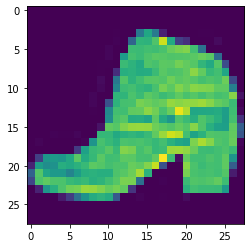

<-------------------Reconstruction------------------->


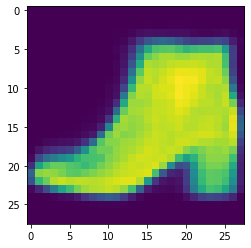



################################################################


Image Number : 2
<-------------------Original Image------------------->


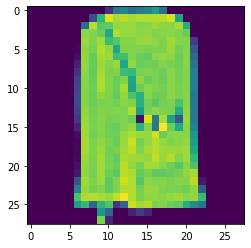

<-------------------Reconstruction------------------->


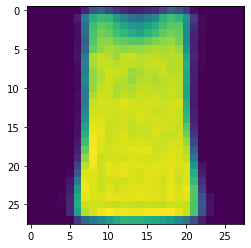



################################################################


Image Number : 3
<-------------------Original Image------------------->


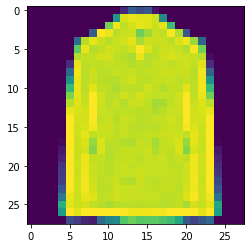

<-------------------Reconstruction------------------->


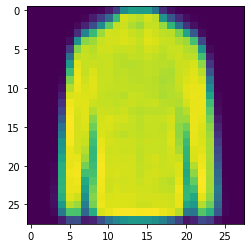



################################################################


Image Number : 4
<-------------------Original Image------------------->


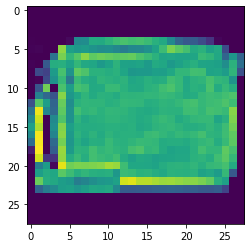

<-------------------Reconstruction------------------->


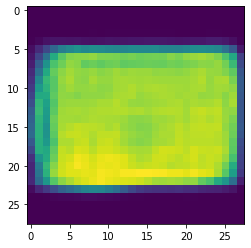



################################################################


Image Number : 5
<-------------------Original Image------------------->


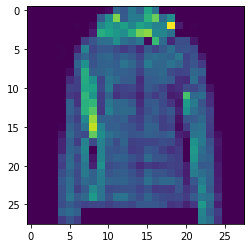

<-------------------Reconstruction------------------->


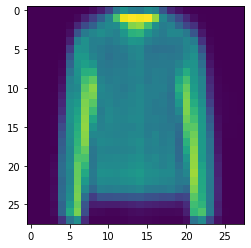



################################################################


Image Number : 6
<-------------------Original Image------------------->


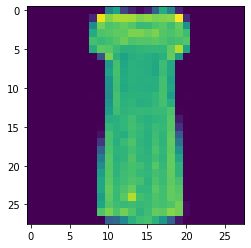

<-------------------Reconstruction------------------->


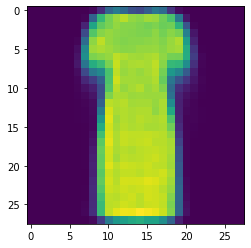



################################################################


Image Number : 7
<-------------------Original Image------------------->


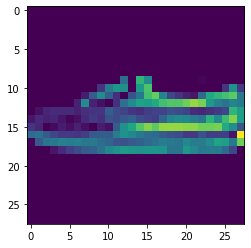

<-------------------Reconstruction------------------->


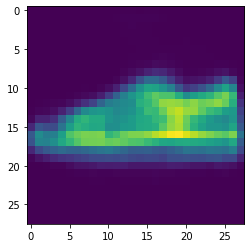



################################################################


Image Number : 8
<-------------------Original Image------------------->


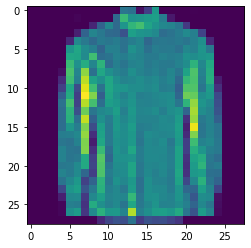

<-------------------Reconstruction------------------->


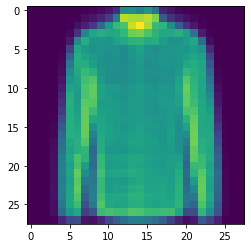



################################################################


Image Number : 9
<-------------------Original Image------------------->


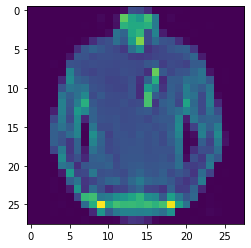

<-------------------Reconstruction------------------->


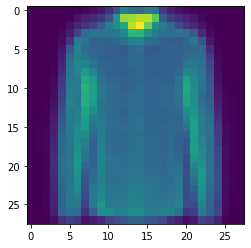



################################################################


Image Number : 10
<-------------------Original Image------------------->


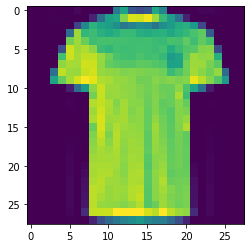

<-------------------Reconstruction------------------->


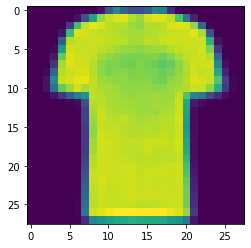



################################################################


Image Number : 11
<-------------------Original Image------------------->


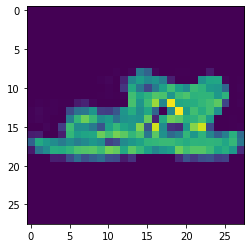

<-------------------Reconstruction------------------->


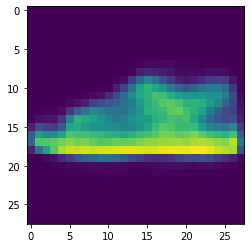



################################################################


Image Number : 12
<-------------------Original Image------------------->


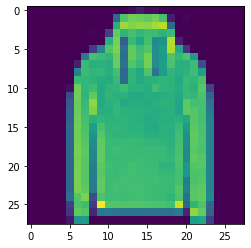

<-------------------Reconstruction------------------->


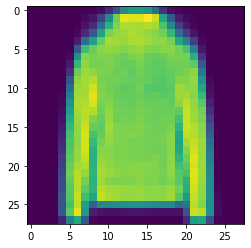



################################################################


Image Number : 13
<-------------------Original Image------------------->


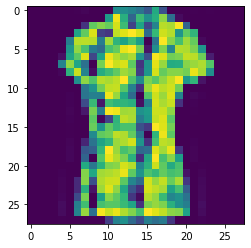

<-------------------Reconstruction------------------->


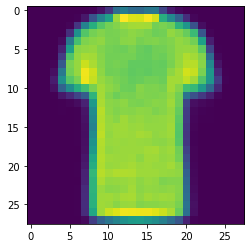



################################################################


Image Number : 14
<-------------------Original Image------------------->


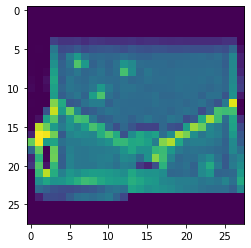

<-------------------Reconstruction------------------->


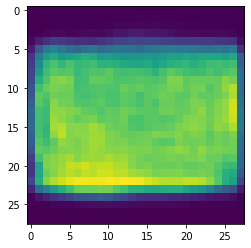



################################################################


Image Number : 15
<-------------------Original Image------------------->


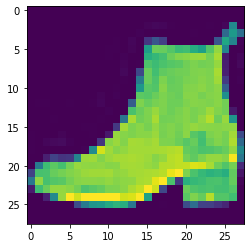

<-------------------Reconstruction------------------->


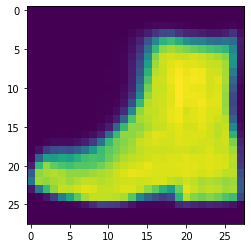



################################################################




In [ ]:
for i in range(15):
  print('Image Number : {}'.format(i+1))
  idx = np.random.randint(0, len(y_train))
  image = x_train[idx % x_train.shape[0], ...]
  plt.imshow(image)
  print("<-------------------Original Image------------------->")
  plt.show()
  pred = vae(image.reshape(1,pixel,pixel))
  plt.imshow(pred[0])
  print("<-------------------Reconstruction------------------->")
  plt.show()
  print("\n")
  print("################################################################")
  print("\n")

Random samples: Randomly generate some images (at least 10) with the VAE; i.e. sample latent variables from the prior distribution, and decode them into data space. Plot the results.

Scatter 3D plot of 1000 cloths


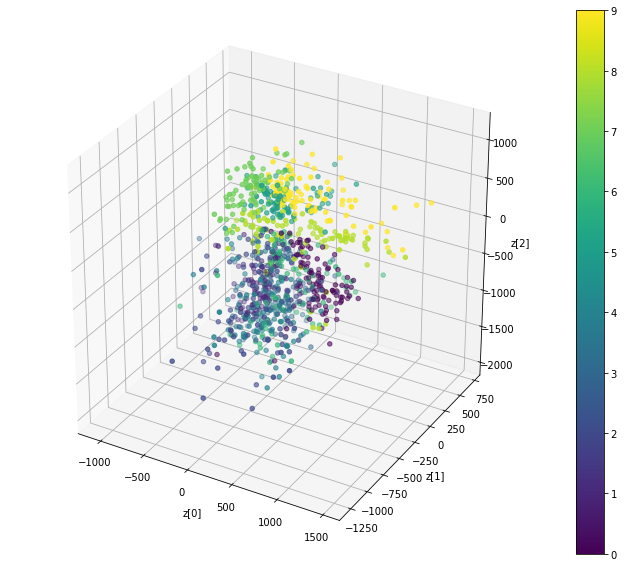

z[0] =  -4


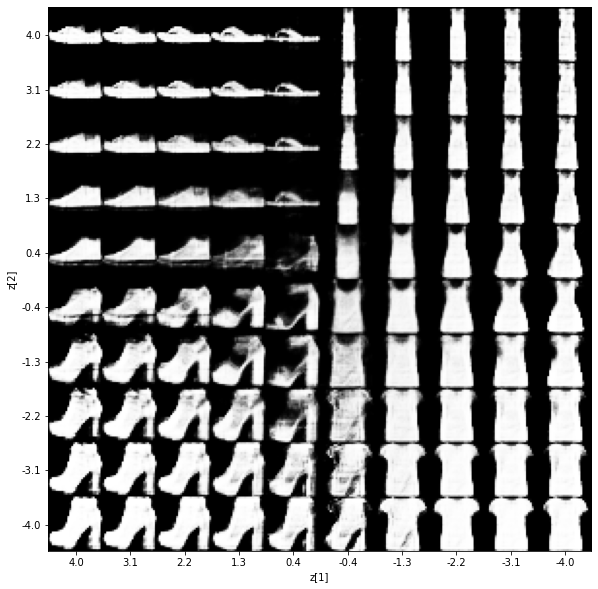

z[0] =  0


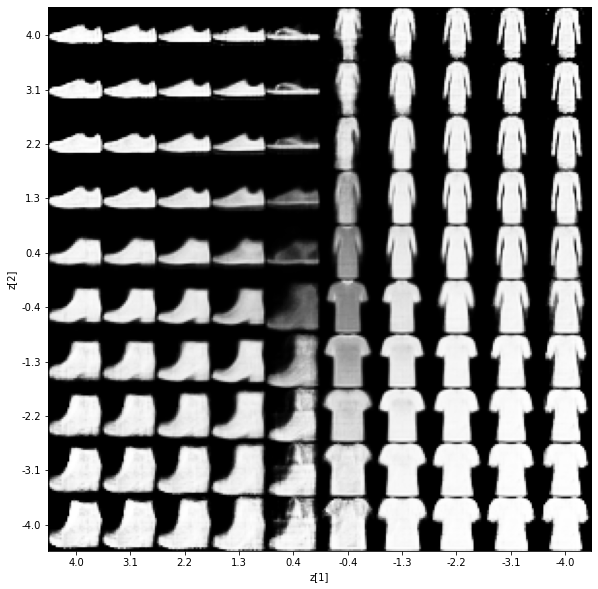

z[0] =  4


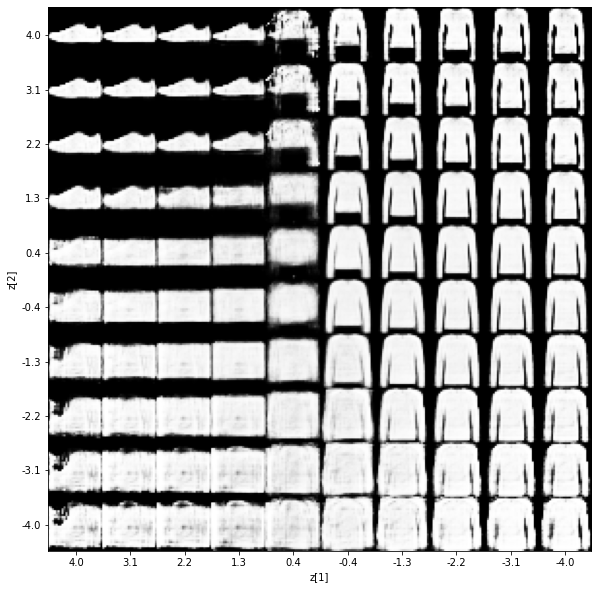

In [ ]:
batch_size = 100

def plot_results(encoder, decoder,x_test, y_test, batch_size):
    # display a 2D plot of the clothing classes in the latent space
    print("Scatter 3D plot of 1000 cloths")
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    z_mu, _ = encoder.predict(x_test, batch_size=batch_size)
    z_mu = z_mu[:1000]
    p = ax.scatter(z_mu[:, 0], z_mu[:, 1], z_mu[:,2], c=y_test[:1000])
    ax.set_xlabel("z[0]")
    ax.set_ylabel("z[1]")
    ax.set_zlabel("z[2]")
    fig.colorbar(p)
    plt.show()
    # display a 10x10 = 100 2D manifold of cloths for z[0]= 4, 0 and -4
    n = 10
    pixels = x_test.shape[1]
    figure = np.zeros((pixels * n, pixels * n, pixels * n))
    # linearly spaced coordinates corresponding to the 2D plot of clothing classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-2]
    grid_z = np.linspace(-4, 4, n)[::-1]

    for k, zi in enumerate(grid_z):
      for i, yi in enumerate(grid_y):
          for j, xi in enumerate(grid_x):
              z_sample = np.array([[xi, yi, zi]])
              x_decoded = decoder.predict(z_sample)
              x_decoded = np.reshape(x_decoded, (x_decoded.shape[0], -1))
              cloth = x_decoded[0].reshape(pixels, pixels)
              figure[i * pixels: (i + 1) * pixels, j * pixels: (j + 1) * pixels, k * pixels: (k + 1) * pixels] = cloth

    start_range = pixels // 2
    end_range = n * pixels + start_range + 1
    pixel_range = np.arange(start_range, end_range, pixels)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    sample_range_z = np.round(grid_z, 1)

    for i in range(3):
      print("z[0] = ", 4*(i-1))
      plt.figure(figsize=(12, 10))
      plt.xticks(pixel_range, sample_range_z)
      plt.yticks(pixel_range, sample_range_z)
      plt.xlabel("z[1]")
      plt.ylabel("z[2]")
      plt.imshow(figure[69*i,...], cmap='Greys_r')
      plt.show()

# plot results
plot_results(encoder, decoder,
             x_test, y_test,
             batch_size=batch_size)

The last 3 plots show 10x10 images corresponding to a portion of the planes z[0]=-4 , z[0]=0 and z[0]= 4, of the 3D Cube. They are shown to have a better understanding of the location of the images on the dimensional space.

## Task 4: Anomaly detection
**(a)** Use the VAE to obtain density/likelihood estimations for the normal and anomalous test sets, i.e. compute the ELBO (the negative of the loss function) for all points in both test sets. Make sure to keep the scores for the normal and anomaly sets separate from each other.

*Implementation hint: Unfortunately, Keras's `.evaluate()` does not allow to access the loss values of individual samples, it only returns the average loss over the entire input. A simple (but slow) workaround is to just use for loops over the entire input and use `.evaluate()` for each data point individually (set `verbose=0` to avoid a long output).*

In [ ]:
#### INSERT CODE HERE ####

ELBO_0 = [] #Normal
ELBO_1 = [] #Anomaly

# ELBO scores for each sample
for i in x_test_0:
      ELBO_0.append(-1 * vae.evaluate(np.expand_dims(i, axis=0), verbose=0))

for i in x_test_1:
      ELBO_1.append(-1 * vae.evaluate(np.expand_dims(i, axis=0), verbose=0))

**(b)** Visualise the scores in a histogram (`plt.hist()`) as well as a density plot (`sns.kdplot` from the `seaborn` library). Use two different colours: **green** for normal data, **red** for anomalous data, and show both normal and anomalous scores in the same plot (use transparency to make visualisation clearer), i.e. one figure with both histograms, and one figure with both density plots.

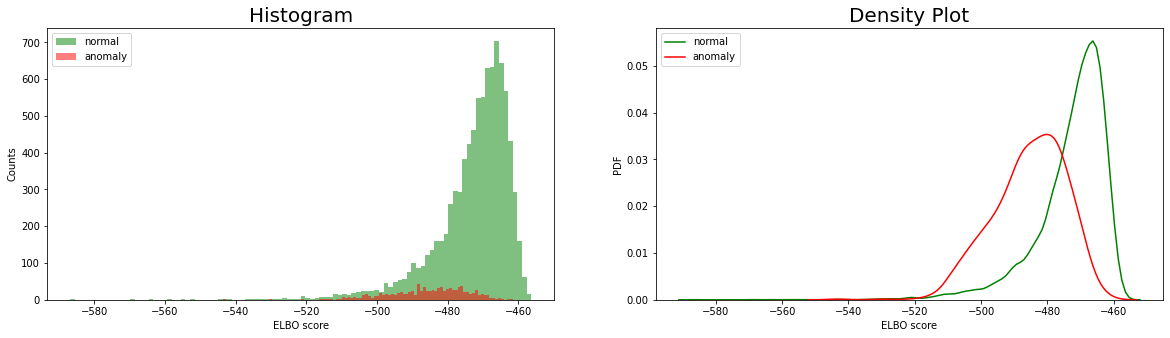

In [ ]:
#### INSERT CODE HERE ####

plt.subplots(1,2, figsize=(20,5))

# plot histogram
plt.subplot(121)
_ = plt.hist(ELBO_0, bins=100, density=False, color='g', alpha=.5, label="normal")
_ = plt.hist(ELBO_1, bins=100, density=False, color='r', alpha=.5, label="anomaly")
plt.xlabel("ELBO score")
plt.ylabel("Counts")
plt.title("Histogram", fontsize = 20, y=1)
plt.legend()

# plot pdf
plt.subplot(122)
_ = sns.kdeplot(ELBO_0, color='g', label="normal")
_ = sns.kdeplot(ELBO_1, color='r', label="anomaly")
plt.xlabel("ELBO score")
plt.ylabel("PDF")
plt.title("Density Plot", fontsize = 20, y=1)
plt.legend()

**(c)** Given these likelihood scores, we can choose a threshold and classify all instances with a likelihood below the threshold as anomalies, and all instances with a likelihood above the threshold as "normal". Different thresholds will give different True/False Positive/Negative scores. We can summarise the performance of all thresholds in an ROC curve, or a Precision-Recall curve (the latter has been shown to be more suitable for imbalanced datasets, see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/).
* Plot an ROC curve for your results, compute and show the Area Under Curve (AUC) score for quantitative evaluation.
* Plot a Precision-Recall curve for your results, compute and show the Area Under Curve (AUC) score for quantitative evaluation.

*Implementation hints:*
* *See https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ for more information about ROC and PR curves and their implementation with `sklearn`.*
* *ROC/PR curves are typically used for binary classification. You can define anomaly as label 0 and normal as 1, and rescale the ELBO scores from part (a) to be between 0 and 1 (by using the minimum and maximum values in your ELBO results) to express them as binary classification probabilities.*

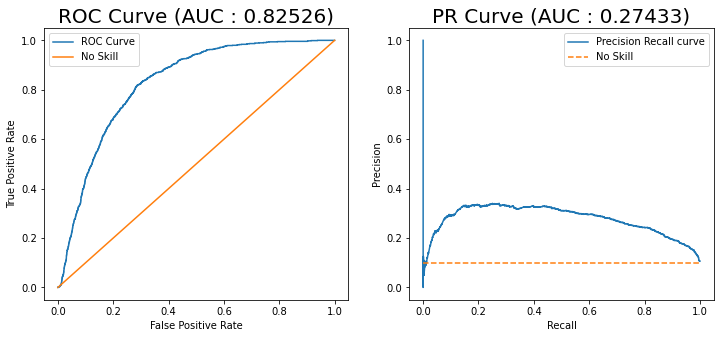

In [ ]:
#### INSERT CODE HERE ####

ELBO = np.array(ELBO_0 + ELBO_1)

ELBO_min = min(ELBO)
ELBO_max = max(ELBO)

prob = 1 - ((ELBO - ELBO_min)/(ELBO_max - ELBO_min))

y = [0]*len(ELBO_0) + [1]*len(ELBO_1)

false_positive, true_positive, _ = roc_curve(y, prob)
precision, recall , _ = precision_recall_curve(y, prob)

noskill_prob = [0 for i in range (len(y))]
noskill_fpr, noskill_tpr, _ = roc_curve(y, noskill_prob)

roc_auc = auc(false_positive, true_positive)
pr_auc = auc(recall, precision)

noskill = len(ELBO_1)/len(y)
noskill_fpr, noskill_tpr, _ = roc_curve(y, noskill_prob)

#<------------------Plotting-------------------------------->

plt.subplots(1,2, figsize=(12,5))

# plot false_positive vs true_positive
plt.subplot(121)
plt.plot(false_positive,true_positive, label="ROC Curve")
plt.plot(noskill_fpr, noskill_tpr, label="No Skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (AUC : {:.5f})".format(roc_auc), fontsize = 20, y=1)
plt.legend()

# plot precison vs recall
plt.subplot(122)
plt.plot(recall, precision, label='Precision Recall curve')
plt.plot([0, 1], [noskill, noskill], linestyle='--', label='No Skill')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.title("PR Curve (AUC : {:.5f})".format(pr_auc), fontsize = 20, y=1)
plt.legend()

**(d)** Ideally, a successful VAE for anomaly detection should represent (and thus reconstruct) normal data very well, but not anomalous data. Reconstruct some random images (at least 10 each) from the normal test set, as well as from the anomaly test set. Show the original images and their reconstructions on top of each other.

NORMAL TEST
Normal Image Number : 1
<-------------------Normal Test Image------------------->


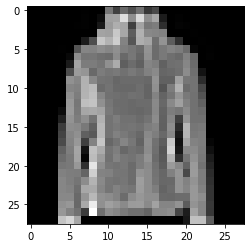

<-------------------Reconstructed Test Image------------------->


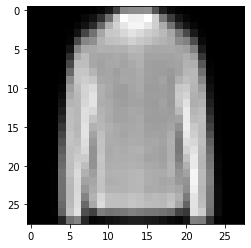



#########################################################################


Normal Image Number : 2
<-------------------Normal Test Image------------------->


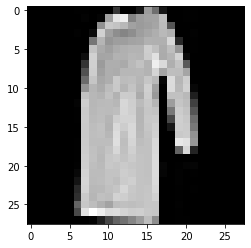

<-------------------Reconstructed Test Image------------------->


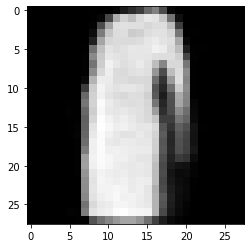



#########################################################################


Normal Image Number : 3
<-------------------Normal Test Image------------------->


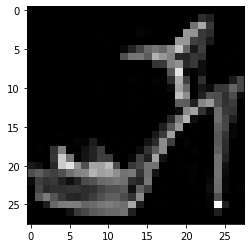

<-------------------Reconstructed Test Image------------------->


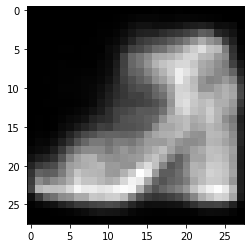



#########################################################################


Normal Image Number : 4
<-------------------Normal Test Image------------------->


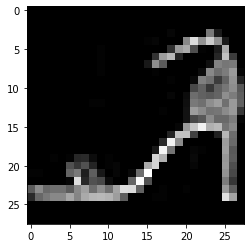

<-------------------Reconstructed Test Image------------------->


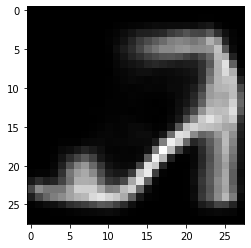



#########################################################################


Normal Image Number : 5
<-------------------Normal Test Image------------------->


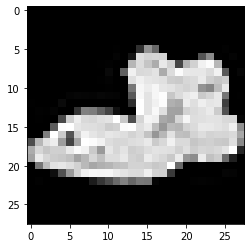

<-------------------Reconstructed Test Image------------------->


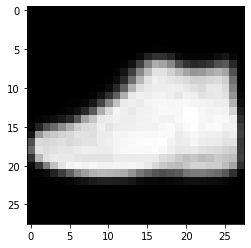



#########################################################################


Normal Image Number : 6
<-------------------Normal Test Image------------------->


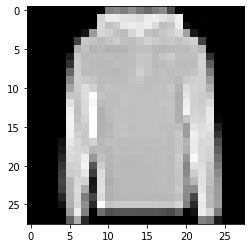

<-------------------Reconstructed Test Image------------------->


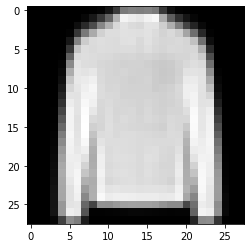



#########################################################################


Normal Image Number : 7
<-------------------Normal Test Image------------------->


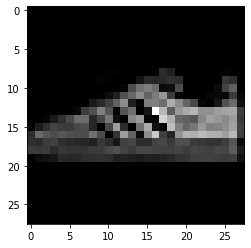

<-------------------Reconstructed Test Image------------------->


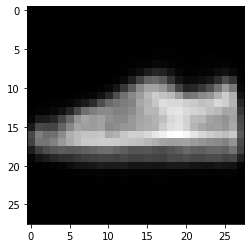



#########################################################################


Normal Image Number : 8
<-------------------Normal Test Image------------------->


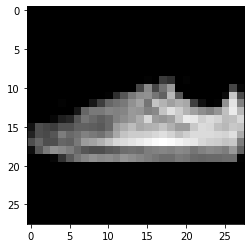

<-------------------Reconstructed Test Image------------------->


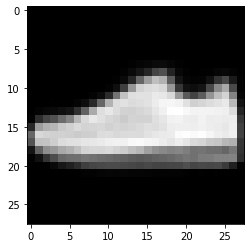



#########################################################################


Normal Image Number : 9
<-------------------Normal Test Image------------------->


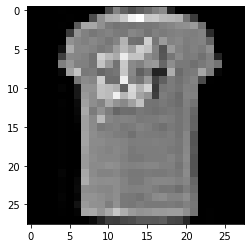

<-------------------Reconstructed Test Image------------------->


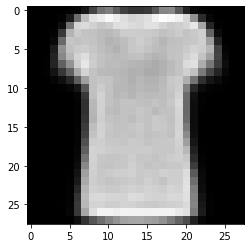



#########################################################################


Normal Image Number : 10
<-------------------Normal Test Image------------------->


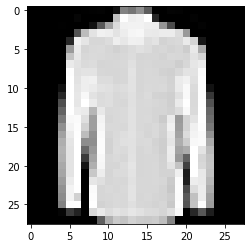

<-------------------Reconstructed Test Image------------------->


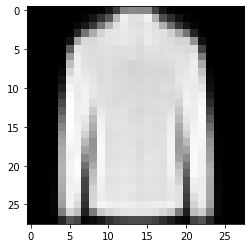



#########################################################################




In [ ]:
#### INSERT CODE HERE ####

#On Normal Data
nx = x_test_0.shape[0]
idx = np.random.choice(nx, size=10, replace=False)
ind = np.random.randint(0, nx, size=10)
sample_normal = x_test_0[ind]
reconstruction_normal = vae.predict(sample_normal)
print("NORMAL TEST")
for i in range(10):
   print('Normal Image Number : {}'.format(i+1))
   plt.imshow(sample_normal[i].reshape(pixel,pixel), cmap='gray')
   print("<-------------------Normal Test Image------------------->")
   plt.show()
   plt.imshow(reconstruction_normal[i].reshape(pixel,pixel), cmap='gray')
   print("<-------------------Reconstructed Test Image------------------->")
   plt.show()
   print("\n")
   print("#########################################################################")
   print("\n")

ANOMALY TEST
Anomaly Image Number : 1
<-------------------Anomaly Test Image------------------->


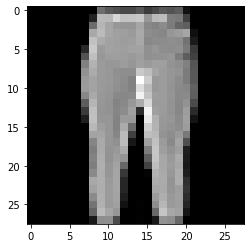

<-------------------Reconstructed Test Image------------------->


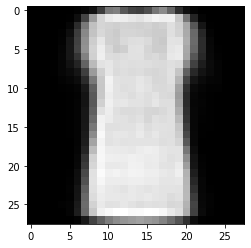



#########################################################################


Anomaly Image Number : 2
<-------------------Anomaly Test Image------------------->


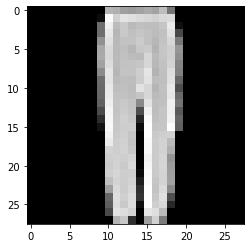

<-------------------Reconstructed Test Image------------------->


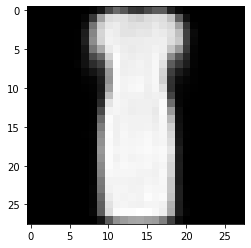



#########################################################################


Anomaly Image Number : 3
<-------------------Anomaly Test Image------------------->


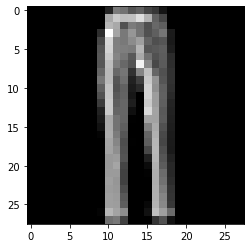

<-------------------Reconstructed Test Image------------------->


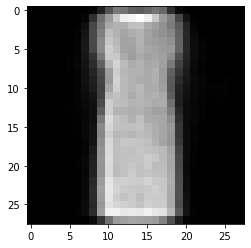



#########################################################################


Anomaly Image Number : 4
<-------------------Anomaly Test Image------------------->


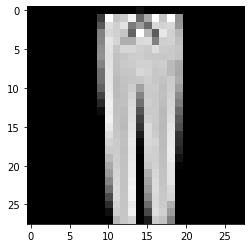

<-------------------Reconstructed Test Image------------------->


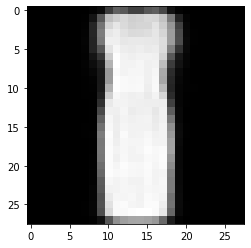



#########################################################################


Anomaly Image Number : 5
<-------------------Anomaly Test Image------------------->


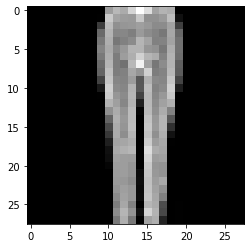

<-------------------Reconstructed Test Image------------------->


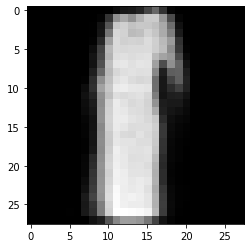



#########################################################################


Anomaly Image Number : 6
<-------------------Anomaly Test Image------------------->


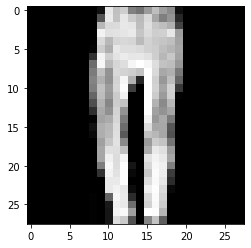

<-------------------Reconstructed Test Image------------------->


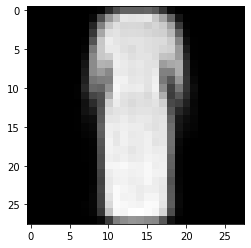



#########################################################################


Anomaly Image Number : 7
<-------------------Anomaly Test Image------------------->


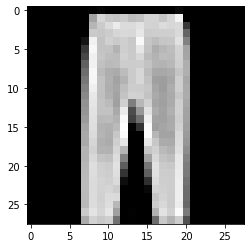

<-------------------Reconstructed Test Image------------------->


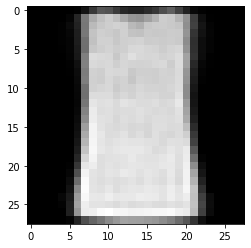



#########################################################################


Anomaly Image Number : 8
<-------------------Anomaly Test Image------------------->


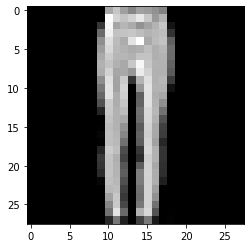

<-------------------Reconstructed Test Image------------------->


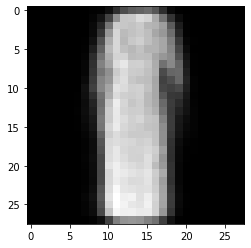



#########################################################################


Anomaly Image Number : 9
<-------------------Anomaly Test Image------------------->


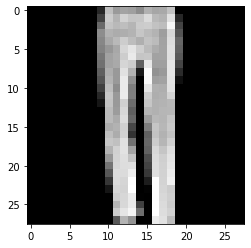

<-------------------Reconstructed Test Image------------------->


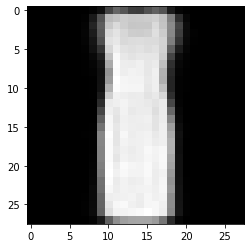



#########################################################################


Anomaly Image Number : 10
<-------------------Anomaly Test Image------------------->


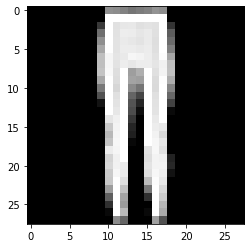

<-------------------Reconstructed Test Image------------------->


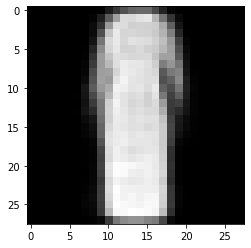



#########################################################################




In [ ]:
#On Anomaly Data
nx = x_test_1.shape[0]
idx = np.random.choice(nx, size=10, replace=False)
ind = np.random.randint(0, nx, size=10)
sample_anomaly = x_test_1[ind]
reconstruction_anomaly = vae.predict(sample_anomaly)
print("ANOMALY TEST")
for i in range(10):
   print('Anomaly Image Number : {}'.format(i+1))
   plt.imshow(sample_anomaly[i].reshape(pixel,pixel), cmap='gray')
   print("<-------------------Anomaly Test Image------------------->")
   plt.show()
   plt.imshow(reconstruction_anomaly[i].reshape(pixel,pixel), cmap='gray')
   print("<-------------------Reconstructed Test Image------------------->")
   plt.show()
   print("\n")
   print("#########################################################################")
   print("\n")

**(e)** Give a detailed discussion of your results; does the anomaly detection perform well? Why do you think so? What could be improved? Discuss each of the results from parts (b), (c), and (d) separately.

<-- WRITE TEXT HERE -->

Answer (b):  Task 4(b) 's left subfigure displays the histogram indicating that the dataset is left-skewed, which means that it is highly imbalanced because the amount of anomalous data is limited since we choose the trousers. Though Anomalous Data's ELBO score is entirely contained in Normal Data's ELBO score.

The right Task 4(b) subfigure shows the Normal and Anomalous Density plot. The ELBO score is (log) a data likelihood; we can deduce that (log) anomalous data likelihood is lower than that of normal data. We note that while there is some similarity, all data points may be distinguished from regular and anomalous data points.
The right Task 4(b) subfigure shows the Normal and Anomalous Density plot. The ELBO score is (log) a data likelihood. The ELBO score is (log) likelihood of the data; we can deduce that (log) likelihood of anomalous data is lower than that of normal data. We note that while there is some overlap, all data points may be separated from regular and anomalous data points. The data points which have ELBO scores below -480 are more likely to be anomalies. Since all the data points are below $[-600, -450]$, it is challenging to identify phenomena with 100\%on for this is that VAEs are known for blurry rebuilding.


Answer (c) : Task 4(c) 's we observed that the ROC area under the curve is approximately equal to 0.82, which implies a better performance of the random guessing (Orange Dashed Line). As mentioned for Task 4(b), the dataset is unbalanced, so it seems like the ROC curve is deceptive.

Similarly, under the curve, the PR equation region is approximately equivalent to 0.27, which means that the model has learned something more than having no skill, while it seems ideal.

Answer (d) : From the reconstruction in Task 4(d), we conclude that normal images are reconstructed pretty accurately and can reproduce the samples from the normal test data, although some details are lost.

In the anomalous data reconstruction, trousers are reproduced as similar shape-like dresses or t-shirts, which have nearly the same width compared to purses, shoes, and sandals. If the source image can be compared with the anomaly, the image anomaly can be detected, but it is not possible during computation. We can assume from the above that the model did not identify the anomalous detection well but can be fine-tuned by re-designing the architecture and adjusting the hyperparameters and latent dimensions.